In [2]:
import psycopg2

In [3]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [7]:
try:
    cursor.execute("SELECT * FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5)")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [8]:
len(pairs)

284340

In [9]:
adjs = list(set([pair[0] for pair in pairs]))
nouns = list(set([pair[1] for pair in pairs]))

In [10]:
print(len(nouns), len(adjs))

10521 20266


## Finding similarities of words

Deciding the similarity of each pair of two different nouns based on how many adjectives they have in common (adjectives that were used to describe them in the texts).

In [29]:
try:
    cursor.execute("SELECT DISTINCT noun, STRING_AGG(adjective, ',') FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5) GROUP BY noun")
    adjectives_listed = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [32]:
adjectives_listed[:3]

[('iseolemine',
  'sõjaeelne,kultuuriline,poliitiline,tavapärane,riiklik,muutumatu,ideoloogilis-poliitiline,rahvuslik'),
 ('detektor',
  'piisav,tundlik,iseloomulik,tulnud,mõõtev,suur,vastav,armetu,uus,kuuluv'),
 ('aastamiljon', 'pikk,püsiv,järgnev,terve,viimane,energeetiline')]

In [31]:
dict_words = {}

for tup in adjectives_listed:
    dict_words[tup[0]] = tup[1].split(',')

In [14]:
import itertools

In [17]:
noun_pairs = list(itertools.combinations(nouns, 2))

In [18]:
len(noun_pairs)

55340460

In [25]:
noun_pairs[0]

('kitsendus', 'festival')

In [33]:
len(set(dict_words['kitsendus']) & set(dict_words['festival']))/len(set(dict_words['kitsendus']) | set(dict_words['festival']))

0.0273972602739726

In [40]:
import time
from datetime import timedelta, datetime

In [45]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

similarities = {}

for pair in noun_pairs:
    first_word = pair[0]
    second_word = pair[1]
    similarities[pair] = len(set(dict_words[first_word]) & set(dict_words[second_word]))/len(set(dict_words[first_word]) | set(dict_words[second_word]))
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

23:26:58.899620
23:43:30.172390
0:16:31.311651


In [53]:
similarities2 = {}

for pair, similarity in similarities.items():
    first = pair[0]
    second = pair[1]
    
    if first in similarities2:
        similarities2[first][second] = similarity
    else:
        similarities2[first] = {second: similarity}
        
    if second in similarities2:
        similarities2[second][first] = similarity
    else:
        similarities2[second] = {first: similarity}

### t-SNE on similarity matrix

In [48]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [50]:
import pandas as pd

In [54]:
df = pd.DataFrame(similarities2)

In [55]:
df

,kitsendus,festival,maksulaekumine,säilitamine,minimeerimine,kraam,müügihind,sundus,põllumajandusminister,ennust,...,terviklikkus,poolkera,hotellituba,etteheide,otstarbekus,tähtaeg,avaldusvorm,teatrimärk,lähitulevik,kompartei
festival,0.027397,NaN,0.000000,0.055118,0.000000,0.039604,0.057971,0.015152,0.066667,0.000000,...,0.000000,0.0,0.000000,0.012987,0.013514,0.042735,0.000000,0.015873,0.046875,0.038961
maksulaekumine,0.041667,0.000000,NaN,0.012048,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.034483
säilitamine,0.010638,0.055118,0.012048,NaN,0.011494,0.016260,0.021978,0.011628,0.024390,0.000000,...,0.057471,0.0,0.024096,0.031579,0.021505,0.051852,0.012346,0.000000,0.023529,0.041667
minimeerimine,0.074074,0.000000,0.000000,0.011494,NaN,0.000000,0.038462,0.000000,0.000000,0.058824,...,0.040000,0.0,0.000000,0.066667,0.000000,0.041096,0.000000,0.000000,0.000000,0.000000
kraam,0.015385,0.039604,0.000000,0.016260,0.000000,NaN,0.049180,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.014706,0.000000,0.036697,0.000000,0.018519,0.017544,0.044118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
avaldusvorm,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
teatrimärk,0.041667,0.015873,0.000000,0.000000,0.000000,0.018519,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.014085,0.000000,NaN,0.000000,0.034483
lähitulevik,0.000000,0.046875,0.000000,0.023529,0.000000,0.017544,0.083333,0.052632,0.062500,0.000000,...,0.041667,0.0,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,NaN,0.031250
kompartei,0.051282,0.038961,0.034483,0.041667,0.000000,0.044118,0.026316,0.000000,0.034483,0.000000,...,0.000000,0.0,0.000000,0.000000,0.025000,0.035294,0.000000,0.034483,0.031250,NaN


In [56]:
df = df.reindex(sorted(df.columns), axis=1)
df = df.reindex(sorted(df.index), axis=0)

In [58]:
df = df.fillna(0)

In [59]:
df

,A-klass,Bondi-film,C-vitamiin,CD-plaat,CMOS-tehnoloogia,DK-vahend,DRAM-lülitus,E-pomm,E-vitamiin,GSM-võrk,...,üürikorter,üürimaja,üürisuvila,üürnik,šanss,šokk,žanr,žanrisüsteem,žest,žürii
A-klass,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095238,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
Bondi-film,0.0,0.000000,0.000000,0.071429,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038462,0.133333,0.000000,0.040000,0.045455,0.047619,0.022727,0.00000,0.0,0.062500
C-vitamiin,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.111111,0.000000,...,0.000000,0.083333,0.111111,0.047619,0.055556,0.058824,0.025000,0.00000,0.0,0.000000
CD-plaat,0.1,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.076923,0.000000,0.095238,0.052632,0.055556,0.024390,0.00000,0.0,0.076923
CMOS-tehnoloogia,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
šokk,0.0,0.047619,0.058824,0.055556,0.0,0.047619,0.000000,0.055556,0.058824,0.000000,...,0.033333,0.105263,0.058824,0.034483,0.080000,0.000000,0.042553,0.00000,0.0,0.105263
žanr,0.0,0.022727,0.025000,0.024390,0.0,0.000000,0.024390,0.024390,0.025000,0.108108,...,0.038462,0.047619,0.051282,0.019231,0.111111,0.042553,0.000000,0.04878,0.0,0.023256
žanrisüsteem,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,0.00000,0.0,0.000000
žest,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000


In [69]:
df.to_csv("df_with_similarities_10k.csv")

In [62]:
tsne = TSNE(random_state=17)
tsne_results = tsne.fit_transform(df.values)

In [71]:
import numpy as np

In [72]:
np.save('tsne_10k_results.npy', tsne_results)
# np.load('tsne.npy')

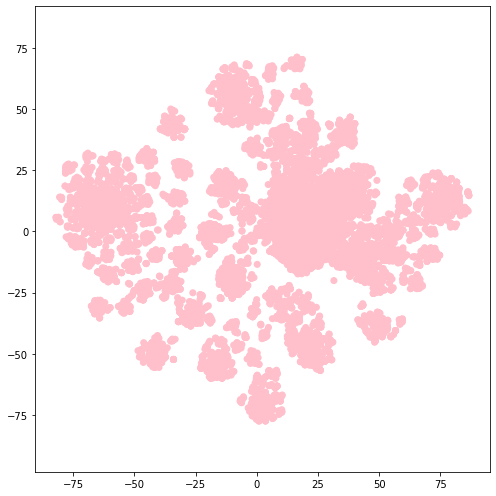

In [73]:
plt.figure(figsize=(7, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

kmeansi plot (punktid) - see leiab klastri keskpunktid
-70 ja 10
sagedaste omadussõnade histogramm
järjesta sõnad sageduse järgi
punkti suurusega sagedus
top 20 sõna pildi peale

omadussõnadest ka graafik

In [81]:
tsne_results.shape

(10521, 2)

#### Exploring smaller subgroups

Currently assuming the results of t-SNE are in the same order as the words in the dataframe, will look into this later.

In [90]:
new_tsne_results = []
results_with_words = []

for i, result in enumerate(tsne_results):
    if result[0] > 57.5 and result[1] < -25:
        new_tsne_results.append(result)
        results_with_words.append([result, df.columns[i]])

In [91]:
len(new_tsne_results)

19

In [93]:
results_with_words

[[array([ 58.923492, -36.330746], dtype=float32), 'arvutikomplekt'],
 [array([ 58.511322, -37.90828 ], dtype=float32), 'e-pangandus'],
 [array([ 58.201675, -36.02285 ], dtype=float32), 'elamurajoon'],
 [array([ 59.552544, -35.72557 ], dtype=float32), 'infokanal'],
 [array([ 58.758   , -36.720566], dtype=float32), 'isamaalane'],
 [array([ 58.84491, -36.44017], dtype=float32), 'kaitsekulutus'],
 [array([ 59.479164, -35.900948], dtype=float32), 'kasutuselevõtmine'],
 [array([ 58.444504, -36.632168], dtype=float32), 'linnavõim'],
 [array([ 59.30101 , -36.018623], dtype=float32), 'maailmapoliitika'],
 [array([ 59.375183, -35.940887], dtype=float32), 'mobiilside'],
 [array([ 58.49458, -37.85811], dtype=float32), 'pommiähvardus'],
 [array([ 59.038902, -35.901638], dtype=float32), 'pürgimus'],
 [array([ 59.048447, -36.295227], dtype=float32), 'sigadus'],
 [array([ 58.854618, -36.473793], dtype=float32), 'sotsiaalteadlane'],
 [array([ 58.68834 , -36.935997], dtype=float32), 'transpordikulu'],
 

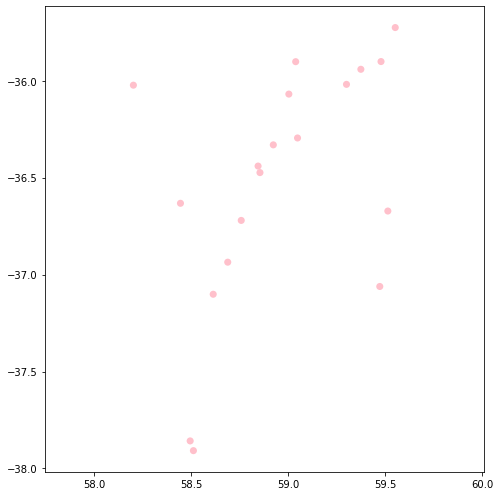

In [92]:
plt.figure(figsize=(7, 7))
plt.scatter([r[0] for r in new_tsne_results], [r[1] for r in new_tsne_results], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

## t-SNE on colours

In [1]:
colours = ["valge", "kollane", "oranž", "roosa", "punane", "pruun", "roheline", "sinine", "lilla", "hall", "must"]

In [4]:
try:
    cursor.execute("SELECT * FROM pair_counts_10000 WHERE adjective IN (SELECT adjective FROM pair_counts_10000 GROUP BY adjective HAVING COUNT(*) >= 5)")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [5]:
adjs = list(set([pair[0] for pair in pairs]))
nouns = list(set([pair[1] for pair in pairs]))

In [6]:
print(len(pairs), len(adjs), len(nouns))

333728 6302 59204


In [8]:
try:
    cursor.execute("SELECT DISTINCT adjective, STRING_AGG(noun, ',') FROM pair_counts_10000 WHERE adjective IN (SELECT adjective FROM pair_counts_10000 GROUP BY adjective HAVING COUNT(*) >= 5) GROUP BY adjective")
    nouns_listed = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [9]:
dict_adjs = {}

for tup in nouns_listed:
    dict_adjs[tup[0]] = tup[1].split(',')

In [11]:
len(dict_adjs)

6302

In [10]:
import itertools

In [12]:
adj_pairs = list(itertools.combinations(adjs, 2))

In [13]:
import time
from datetime import timedelta, datetime

In [14]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

adj_similarities = {}

for pair in adj_pairs:
    first = pair[0]
    second = pair[1]
    similarity = len(set(dict_adjs[first]) & set(dict_adjs[second]))/len(set(dict_adjs[first]) | set(dict_adjs[second]))
    
    
    if first in adj_similarities:
        adj_similarities[first][second] = similarity
    else:
        adj_similarities[first] = {second: similarity}
        
    if second in adj_similarities:
        adj_similarities[second][first] = similarity
    else:
        adj_similarities[second] = {first: similarity}
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

1:41:33.519569
1:51:11.430584
0:09:37.911017


In [16]:
import pandas as pd

In [17]:
df2 = pd.DataFrame(adj_similarities)

In [18]:
df2

,sotsiaalpoliitiline,kodutu,tammsaarelik,humanistlik,sugudevaheline,peen,miljardine,lineaarne,multifunktsionaalne,põhjapoolne,...,vettpidav,põhjamaine,vähenev,otsatu,200grammine,tuletatav,kulukas,tõusiklik,mõõtuandev,reklaamitav
kodutu,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.022727,...,0.000000,0.009804,0.013514,0.0,0.018868,0.0,0.015038,0.000000,0.000000,0.000000
tammsaarelik,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
humanistlik,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.030303,0.000000
sugudevaheline,0.000000,0.000000,0.0,0.000000,NaN,0.000000,0.000000,0.012658,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.010753,0.000000,0.083333,0.000000
peen,0.000000,0.000000,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.007042,...,0.000000,0.006452,0.007874,0.0,0.000000,0.0,0.005348,0.009091,0.000000,0.009259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kulukas,0.009174,0.015038,0.0,0.000000,0.010753,0.005348,0.020833,0.025316,0.021053,0.015504,...,0.010204,0.014085,0.017544,0.0,0.000000,0.0,NaN,0.000000,0.000000,0.000000
tõusiklik,0.000000,0.000000,0.0,0.000000,0.000000,0.009091,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015152,0.000000,0.0,0.000000,0.0,0.000000,NaN,0.000000,0.000000
mõõtuandev,0.000000,0.000000,0.0,0.030303,0.083333,0.000000,0.000000,0.012500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.000000
reklaamitav,0.000000,0.000000,0.0,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,NaN


In [19]:
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.reindex(sorted(df2.index), axis=0)
df2 = df2.fillna(0)

In [20]:
df2

,%line,000dollariline,000kroonine,000meheline,000tonnine,10%line,10-14aastane,1000kroonine,100aastane,100grammine,...,ümbertehtud,ümbertöötatud,ümbritsev,ümmargune,ürgne,üritav,üsasisene,ütelnud,üürike,šokeeriv
%line,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.008547,0.024691,0.000000,0.0,0.0,0.000000,0.000000,0.0
000dollariline,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
000kroonine,0.0,0.0,0.000000,0.0,0.0,0.008929,0.0,0.017391,0.0,0.009091,...,0.0,0.0,0.012346,0.011561,0.012658,0.0,0.0,0.008333,0.016393,0.0
000meheline,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
000tonnine,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
üritav,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
üsasisene,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.004348,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
ütelnud,0.0,0.0,0.008333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.004237,0.000000,0.029851,0.0,0.0,0.000000,0.000000,0.0
üürike,0.0,0.0,0.016393,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.008403,0.011628,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [28]:
colours_in_df = [colour for colour in colours if colour in df2.index]

In [31]:
df2.loc[colours_in_df][colours_in_df]

,valge,kollane,roosa,punane,pruun,roheline,sinine,lilla,hall,must
valge,0.000000,0.060893,0.030211,0.100881,0.032209,0.071836,0.073469,0.014778,0.066576,0.126134
kollane,0.060893,0.000000,0.052632,0.054054,0.020325,0.068041,0.069971,0.015544,0.043103,0.051348
roosa,0.030211,0.052632,0.000000,0.029160,0.049296,0.022113,0.051587,0.032967,0.035714,0.033141
punane,0.100881,0.054054,0.029160,0.000000,0.036842,0.084703,0.091049,0.011321,0.063540,0.101711
pruun,0.032209,0.020325,0.049296,0.036842,0.000000,0.020050,0.053498,0.024096,0.058824,0.036603
roheline,0.071836,0.068041,0.022113,0.084703,0.020050,0.000000,0.071721,0.011494,0.046371,0.059783
sinine,0.073469,0.069971,0.051587,0.091049,0.053498,0.071721,0.000000,0.015152,0.069767,0.075718
lilla,0.014778,0.015544,0.032967,0.011321,0.024096,0.011494,0.015152,0.000000,0.020725,0.006163
hall,0.066576,0.043103,0.035714,0.063540,0.058824,0.046371,0.069767,0.020725,0.000000,0.081794
must,0.126134,0.051348,0.033141,0.101711,0.036603,0.059783,0.075718,0.006163,0.081794,0.000000


In [32]:
colours_df = df2.loc[colours_in_df][colours_in_df]
colours_df

,valge,kollane,roosa,punane,pruun,roheline,sinine,lilla,hall,must
valge,0.000000,0.060893,0.030211,0.100881,0.032209,0.071836,0.073469,0.014778,0.066576,0.126134
kollane,0.060893,0.000000,0.052632,0.054054,0.020325,0.068041,0.069971,0.015544,0.043103,0.051348
roosa,0.030211,0.052632,0.000000,0.029160,0.049296,0.022113,0.051587,0.032967,0.035714,0.033141
punane,0.100881,0.054054,0.029160,0.000000,0.036842,0.084703,0.091049,0.011321,0.063540,0.101711
pruun,0.032209,0.020325,0.049296,0.036842,0.000000,0.020050,0.053498,0.024096,0.058824,0.036603
roheline,0.071836,0.068041,0.022113,0.084703,0.020050,0.000000,0.071721,0.011494,0.046371,0.059783
sinine,0.073469,0.069971,0.051587,0.091049,0.053498,0.071721,0.000000,0.015152,0.069767,0.075718
lilla,0.014778,0.015544,0.032967,0.011321,0.024096,0.011494,0.015152,0.000000,0.020725,0.006163
hall,0.066576,0.043103,0.035714,0.063540,0.058824,0.046371,0.069767,0.020725,0.000000,0.081794
must,0.126134,0.051348,0.033141,0.101711,0.036603,0.059783,0.075718,0.006163,0.081794,0.000000


In [40]:
colours_df[colours_df > 0].min()

valge       0.014778
kollane     0.015544
roosa       0.022113
punane      0.011321
pruun       0.020050
roheline    0.011494
sinine      0.015152
lilla       0.006163
hall        0.020725
must        0.006163
dtype: float64

## LDA on nouns and t-SNE based on that

In [46]:
try:
    cursor.execute("SELECT * FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5)")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [47]:
len(pairs)

284340

In [48]:
adjs = list(set([pair[0] for pair in pairs]))
nouns = list(set([pair[1] for pair in pairs]))

In [49]:
import pandas as pd
import numpy as np

In [50]:
df3 = pd.DataFrame(0, index=nouns, columns=adjs)
df3.head()

,sotsiaalpoliitiline,põhistav,kodutu,kõhetu,projektivastane,veerandtunnine,tammsaarelik,tähenärijalik,võistkonnapoolne,teraapiline,...,60hektariline,meetodikindel,tõusiklik,keeletüpoloogiline,viieelemendiline,siidpehme,mõõtuandev,reklaamitav,seiklusjanuline,Seli-taoline
pauk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
majandusstruktuur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sissetung,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
koosolek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kuu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
for tup in pairs:
    df3.loc[tup[1], tup[0]] = tup[2]
    
df3.head()

,sotsiaalpoliitiline,põhistav,kodutu,kõhetu,projektivastane,veerandtunnine,tammsaarelik,tähenärijalik,võistkonnapoolne,teraapiline,...,60hektariline,meetodikindel,tõusiklik,keeletüpoloogiline,viieelemendiline,siidpehme,mõõtuandev,reklaamitav,seiklusjanuline,Seli-taoline
pauk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
majandusstruktuur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sissetung,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
koosolek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kuu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model creation and training

In [52]:
from sklearn.decomposition import LatentDirichletAllocation

In [53]:
lda = LatentDirichletAllocation(n_components=500, random_state=1)
lda.fit_transform(df3)

array([[3.27868852e-05, 3.27868852e-05, 3.27868852e-05, ...,
        3.27868852e-05, 3.27868852e-05, 3.27868852e-05],
       [3.33333333e-04, 3.33333333e-04, 3.33333333e-04, ...,
        3.33333333e-04, 3.33333333e-04, 3.33333333e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       ...,
       [2.85714286e-04, 2.85714286e-04, 2.85714286e-04, ...,
        2.85714286e-04, 2.85714286e-04, 2.85714286e-04],
       [3.33333333e-04, 3.33333333e-04, 3.33333333e-04, ...,
        3.33333333e-04, 3.33333333e-04, 3.33333333e-04],
       [1.17647059e-04, 1.17647059e-04, 1.17647059e-04, ...,
        1.17647059e-04, 1.17647059e-04, 1.17647059e-04]])

In [54]:
lda_topics = lda.transform(df3)
lda_topics.shape

(10521, 500)

### Euclidean distances from topics

In [56]:
from collections import defaultdict

In [65]:
ids = list(range(len(nouns)))
id_pairs = list(itertools.combinations(ids, 2))

In [69]:
np.linalg.norm(lda_topics[0] - lda_topics[1])

0.8930273518159851

In [72]:
dist = 0

for i in range(500):
    dist += (lda_topics[0][i] - lda_topics[1][i])**2

In [73]:
np.sqrt(dist)

0.8930273518159851

In [81]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

lda_similarities = defaultdict(dict)

for pair in id_pairs:
    first = pair[0]
    second = pair[1]
    dist = np.linalg.norm(lda_topics[first] - lda_topics[second]) # euclidean distance
    
    lda_similarities[first][second] = dist
    lda_similarities[second][first] = dist
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

1:24:23.640655
1:34:09.196718
0:09:45.557045


In [82]:
noun_sim_df = pd.DataFrame(lda_similarities)

In [83]:
noun_sim_df

,0,1,2,3,4,5,6,7,8,9,...,10511,10512,10513,10514,10515,10516,10517,10518,10519,10520
1,0.893027,NaN,0.754757,0.889258,1.095384,0.760858,0.734971,0.911357,0.791854,0.811523,...,0.810858,0.906965,0.824576,0.810539,0.723131,0.791932,0.823558,0.846006,0.799473,0.998784
2,0.682854,0.754757,NaN,0.677919,0.932021,0.497640,0.457111,0.706641,0.543878,0.558637,...,0.571167,0.700982,0.575937,0.559779,0.603606,0.543974,0.589057,0.620047,0.554868,0.816297
3,0.824456,0.889258,0.677919,NaN,1.013738,0.684670,0.655811,0.842977,0.718987,0.740584,...,0.739837,0.844110,0.754853,0.739502,0.765165,0.719055,0.753735,0.778193,0.727324,0.942061
4,1.047151,1.095384,0.932021,1.013738,NaN,0.936942,0.915891,1.062813,0.960119,0.977902,...,0.977981,1.058998,0.989390,0.977728,0.997279,0.962356,0.988537,1.006440,0.968548,1.138670
5,0.689558,0.760858,0.497640,0.684670,0.936942,NaN,0.467083,0.713131,0.552284,0.580130,...,0.579194,0.707516,0.598250,0.578751,0.611194,0.552390,0.596844,0.627453,0.563138,0.821921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10517,0.753241,0.823558,0.589057,0.753735,0.988537,0.596844,0.563481,0.779679,0.635894,0.660223,...,0.659400,0.774546,0.676200,0.659012,0.670271,0.635986,NaN,0.702169,0.645343,0.880283
10518,0.782497,0.846006,0.620047,0.778193,1.006440,0.627453,0.547846,0.803349,0.664704,0.688016,...,0.687229,0.798367,0.703364,0.686854,0.714404,0.664794,0.702169,NaN,0.673755,0.901315
10519,0.731927,0.799473,0.554868,0.727324,0.968548,0.563138,0.527639,0.754182,0.604361,0.629912,...,0.629055,0.748870,0.646642,0.628644,0.658631,0.604463,0.645343,0.673755,NaN,0.857781
10520,0.945619,0.998784,0.816297,0.942061,1.138670,0.821921,0.798033,0.962938,0.850712,0.869044,...,0.868413,0.957367,0.881239,0.868123,0.890083,0.850774,0.880283,0.901315,0.857781,NaN


In [86]:
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.columns), axis=1)
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.index), axis=0)
noun_sim_df = noun_sim_df.fillna(0)

In [87]:
noun_sim_df

,0,1,2,3,4,5,6,7,8,9,...,10511,10512,10513,10514,10515,10516,10517,10518,10519,10520
0,0.000000,0.893027,0.682854,0.824456,1.047151,0.689558,0.660911,0.849360,0.723642,0.745104,...,0.744363,0.848078,0.759290,0.744029,0.769541,0.723711,0.753241,0.782497,0.731927,0.945619
1,0.893027,0.000000,0.754757,0.889258,1.095384,0.760858,0.734971,0.911357,0.791854,0.811523,...,0.810858,0.906965,0.824576,0.810539,0.723131,0.791932,0.823558,0.846006,0.799473,0.998784
2,0.682854,0.754757,0.000000,0.677919,0.932021,0.497640,0.457111,0.706641,0.543878,0.558637,...,0.571167,0.700982,0.575937,0.559779,0.603606,0.543974,0.589057,0.620047,0.554868,0.816297
3,0.824456,0.889258,0.677919,0.000000,1.013738,0.684670,0.655811,0.842977,0.718987,0.740584,...,0.739837,0.844110,0.754853,0.739502,0.765165,0.719055,0.753735,0.778193,0.727324,0.942061
4,1.047151,1.095384,0.932021,1.013738,0.000000,0.936942,0.915891,1.062813,0.960119,0.977902,...,0.977981,1.058998,0.989390,0.977728,0.997279,0.962356,0.988537,1.006440,0.968548,1.138670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10516,0.723711,0.791932,0.543974,0.719055,0.962356,0.552390,0.516167,0.746203,0.594374,0.620331,...,0.619452,0.740841,0.637307,0.619041,0.649476,0.000000,0.635986,0.664794,0.604463,0.850774
10517,0.753241,0.823558,0.589057,0.753735,0.988537,0.596844,0.563481,0.779679,0.635894,0.660223,...,0.659400,0.774546,0.676200,0.659012,0.670271,0.635986,0.000000,0.702169,0.645343,0.880283
10518,0.782497,0.846006,0.620047,0.778193,1.006440,0.627453,0.547846,0.803349,0.664704,0.688016,...,0.687229,0.798367,0.703364,0.686854,0.714404,0.664794,0.702169,0.000000,0.673755,0.901315
10519,0.731927,0.799473,0.554868,0.727324,0.968548,0.563138,0.527639,0.754182,0.604361,0.629912,...,0.629055,0.748870,0.646642,0.628644,0.658631,0.604463,0.645343,0.673755,0.000000,0.857781


In [100]:
noun_sim_df[noun_sim_df == min(noun_sim_df[noun_sim_df > 0].min())].dropna(how='all')

,0,1,2,3,4,5,6,7,8,9,...,10511,10512,10513,10514,10515,10516,10517,10518,10519,10520
1462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
noun_sim_df.at[1462, 1975]

1.2623506146429883e-07

In [103]:
print(nouns[1462], nouns[1975])

treenitus kivikamakas


### t-SNE on data of Euclidean distances

In [89]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

Start at about 1:40

In [90]:
lda_tsne = TSNE(random_state=17)
lda_tsne_results = lda_tsne.fit_transform(noun_sim_df.values)

In [91]:
np.save('lda_tsne_10k_results.npy', lda_tsne_results)

In [92]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

2:23:12.271787


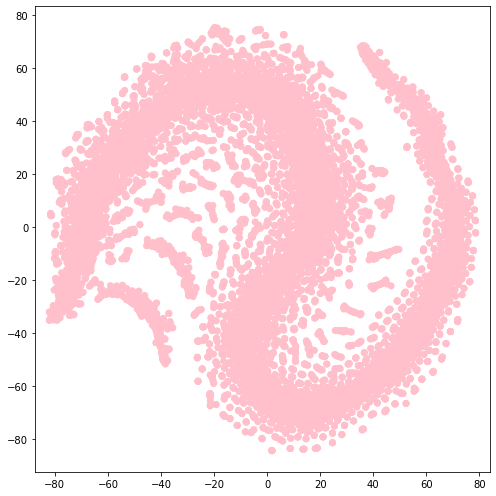

In [93]:
plt.figure(figsize=(7, 7))
plt.scatter(lda_tsne_results[:, 0], lda_tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

võta mingi saba  ja hierarhiline klasterdamine ja mingist kohast lõigata ära
või kmeans
või juhuslik sample ja selle järgi
PCA hoopis selle peal

omadussõnade histogramm ja siis selle järgi et ee mida
heatmap sõnadest
iga rida üks sõna ja veerg üks koordinaat

top 10 omadussõna igas topicus

vaata sõnu millel on mitmene tähendus - nt palk

##### This looks weird so looking into smaller subgroups

In [171]:
lda_tsne_results_smaller = []
smaller_with_words = []

for i, result in enumerate(lda_tsne_results):
    if result[0] > 37.5 and result[0] < 45 and result[1] < -21 and result[1] > -30:
        lda_tsne_results_smaller.append(result)
        smaller_with_words.append([result, nouns[i]])

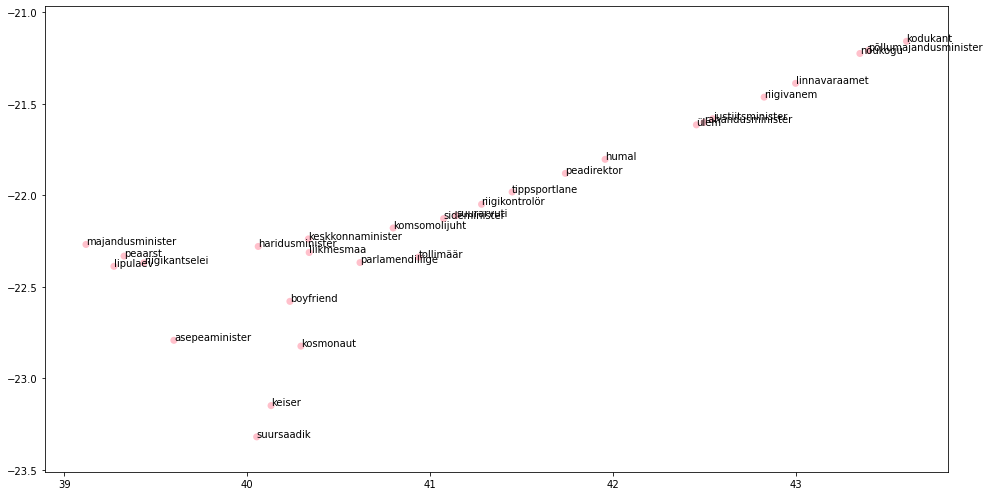

In [176]:
x = [r[0] for r in lda_tsne_results_smaller]
y = [r[1] for r in lda_tsne_results_smaller]
n = [ah[1] for ah in smaller_with_words]

plt.figure(figsize=(14, 7))
plt.scatter(x, y, marker='o', s=50, edgecolor='None', c='pink')

for i, txt in enumerate(n):
    plt.annotate(n[i], (x[i], y[i]))

plt.tight_layout()
plt.axis('equal')
plt.show()

Kõrvale siia see natuke suuremal skaalal:

In [157]:
lda_tsne_results_smaller = []
smaller_with_words = []

for i, result in enumerate(lda_tsne_results):
    if result[0] > 27 and result[0] < 47.5 and result[1] < -21 and result[1] > -32:
        lda_tsne_results_smaller.append(result)
        smaller_with_words.append([result, nouns[i]])

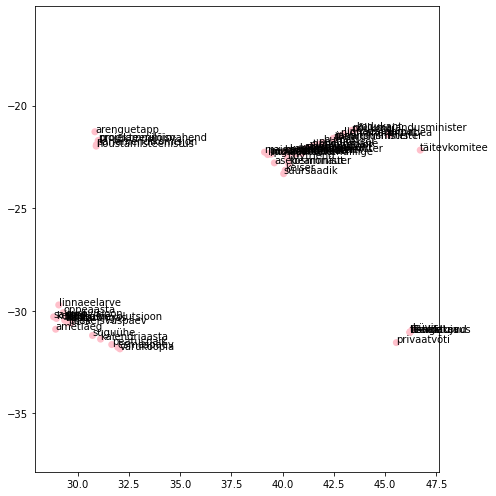

In [158]:
x = [r[0] for r in lda_tsne_results_smaller]
y = [r[1] for r in lda_tsne_results_smaller]
n = [ah[1] for ah in smaller_with_words]

plt.figure(figsize=(7, 7))
plt.scatter(x, y, marker='o', s=50, edgecolor='None', c='pink')

for i, txt in enumerate(n):
    plt.annotate(n[i], (x[i], y[i]))

plt.tight_layout()
plt.axis('equal')
plt.show()

#### Interesting plot (but can't really read anything from it): 

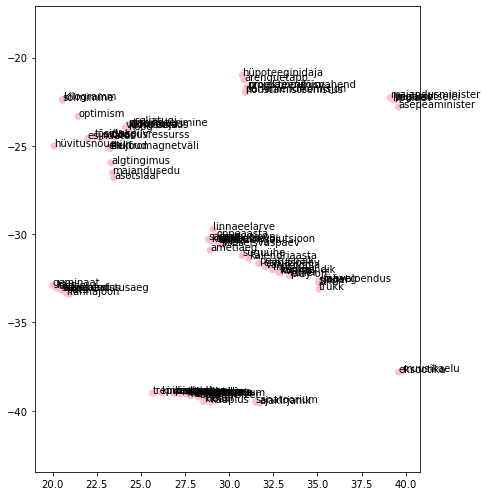

In [118]:
x = [r[0] for r in lda_tsne_results_smaller]
y = [r[1] for r in lda_tsne_results_smaller]
n = [ah[1] for ah in smaller_with_words]

plt.figure(figsize=(7, 7))
plt.scatter(x, y, marker='o', s=50, edgecolor='None', c='pink')

for i, txt in enumerate(n):
    plt.annotate(n[i], (x[i], y[i]))

plt.tight_layout()
plt.axis('equal')
plt.show()